In [14]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import cv2


def set_axis(x, no_labels = 10)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


In [2]:
path_out = '20240507/'
files = glob.glob(path_out+"*")
files.sort()


In [3]:
dx= 5.106500953873407 
dt= 0.0016


data = []
first_filename = files[0]
start = files.index('20240507\\092152.npy')
end = files.index('20240507\\092342.npy')
for file in files[start:end+1]:
   print(f'Loading file: {file}')
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

Loading file: 20240507\092152.npy
Loading file: 20240507\092202.npy
Loading file: 20240507\092212.npy
Loading file: 20240507\092222.npy
Loading file: 20240507\092232.npy
Loading file: 20240507\092242.npy
Loading file: 20240507\092252.npy
Loading file: 20240507\092302.npy
Loading file: 20240507\092312.npy
Loading file: 20240507\092322.npy
Loading file: 20240507\092332.npy
Loading file: 20240507\092342.npy


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_spectrogram(data, original_df=None, fs=(6,8), no_labels=7):
    if not isinstance(data, pd.DataFrame):
        if original_df is None:
            raise ValueError("If data is not a DataFrame, original_df must be provided for index/columns.")
        data = pd.DataFrame(data=np.abs(data), index=original_df.index, columns=original_df.columns)
    
    fig = plt.figure(figsize=fs)
    ax = plt.axes()

    data -= data.mean()
    data = np.abs(data)
    low, high = np.percentile(data, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(data, interpolation='none', aspect='auto', norm=norm, origin='lower')

    # --- Labeling logic ---
    if isinstance(data.index, pd.DatetimeIndex):
        y_positions, y_labels = set_axis(data.index.time,no_labels)
        ax.set_ylabel("Time")
    else:
        y_positions, y_labels = set_axis(data.index.values,no_labels)
        if "freq" in str(data.index.name).lower():
            ax.set_ylabel("Frequency (Hz)")
        else:
            ax.set_ylabel("Time (s)")
    x_positions, x_labels = set_axis(data.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    ax.set_yticks(y_positions, y_labels)

    plt.xlabel("Channels / Spatial Position")
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()

    
def visualize_df(df,fs=(4,8)):
    df = np.array(df)
    fig = plt.figure(figsize=fs)
    ax = plt.axes()
    arr = df.copy()
    arr = arr - arr.mean()
    arr = np.abs(arr)
    low, high = np.percentile(arr, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(arr, interpolation='none', aspect='auto', norm=norm, origin='lower')

    plt.show()
    

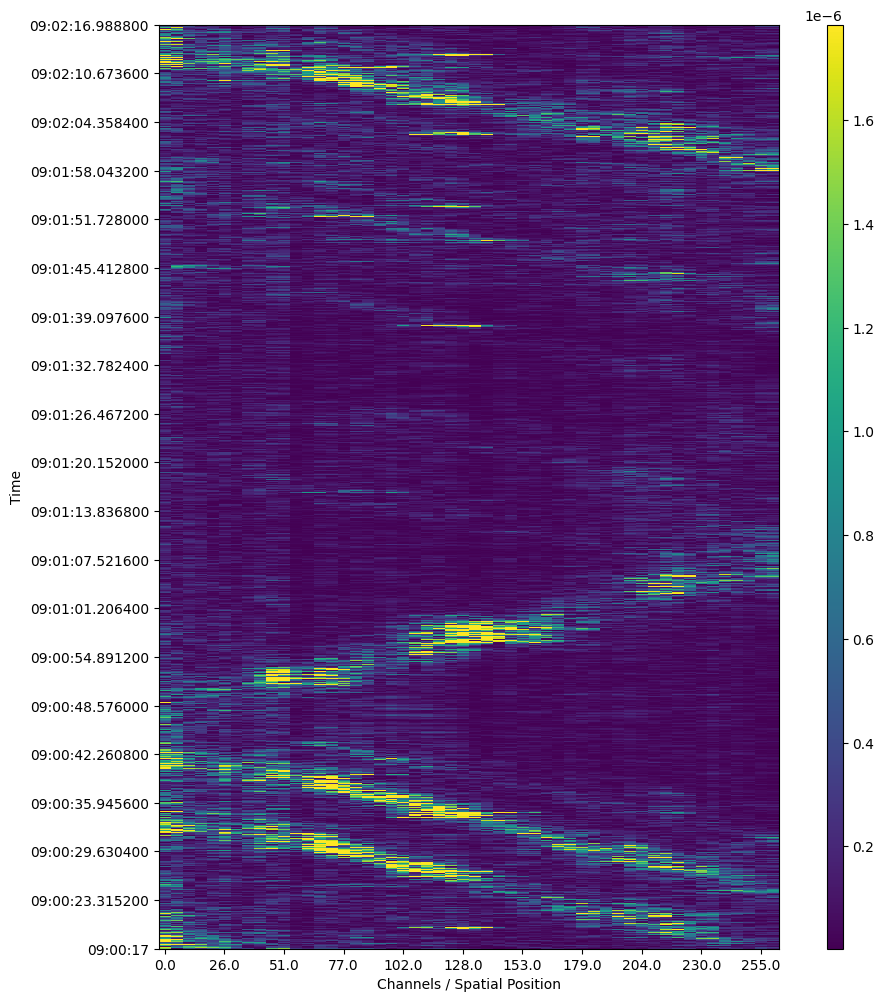

In [5]:
plot_spectrogram(df, fs=(8,12), no_labels=20)

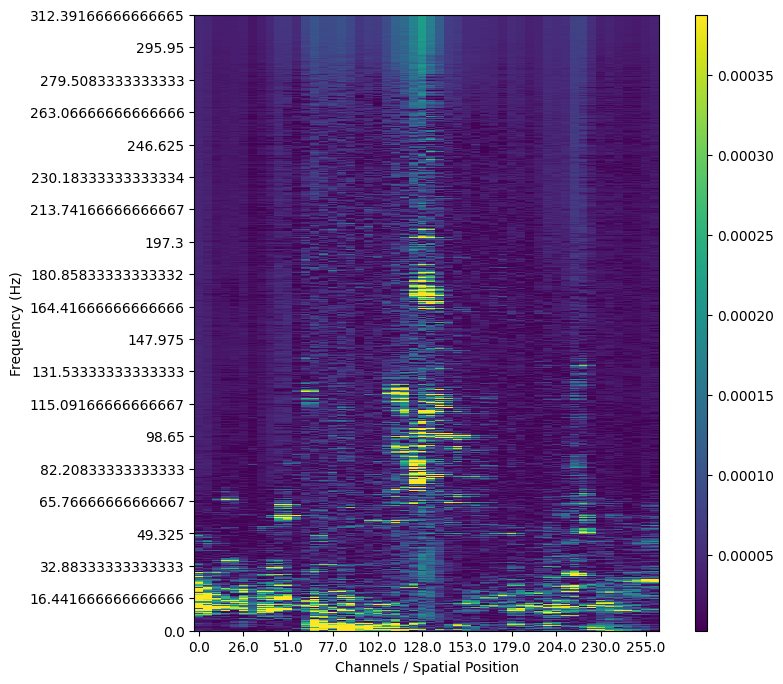

In [6]:
def fft_channels(df, dt):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Only non-negative frequencies (0 ... Nyquist)
    freqs = np.fft.rfftfreq(n, d=dt)

    for channel in df.columns:
        signal = df[channel].values
        
        # Only positive-frequency FFT
        fft_result = np.fft.rfft(signal)

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Real-valued inverse FFT
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df

reverted_df, fft_df = fft_channels(df, dt)
plot_spectrogram(fft_df, fs=(6,8) ,no_labels=20)


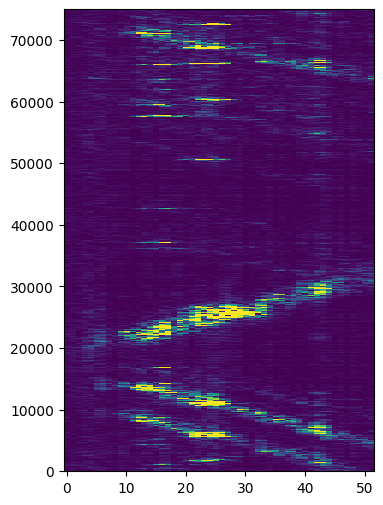

In [12]:
def fft_modify(df, dt, f_min=0, f_max=np.inf):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Only non-negative frequencies (0 ... Nyquist)
    freqs = np.fft.rfftfreq(n, d=dt)

    for channel in df.columns:
        signal = df[channel].values
        # Zero out frequencies outside the desired range
        fft_result = np.fft.rfft(signal)
        fft_result[(freqs < f_min) | (freqs > f_max)] = 0

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Real-valued inverse FFT
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df

reverted_df, fft_df = fft_modify(df, dt, f_min=80, f_max=120)
visualize_df(np.concatenate([reverted_df], axis=1), fs=(4,6))


=== Original ===


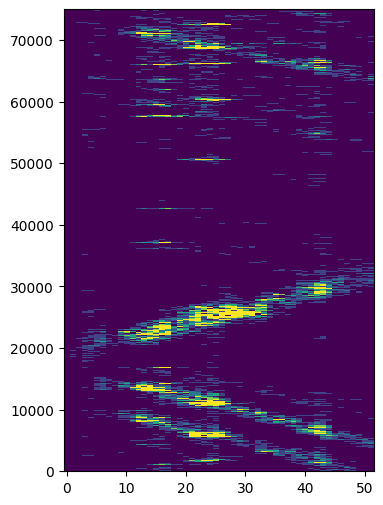


=== CLAHE (2.0, 8x8) ===


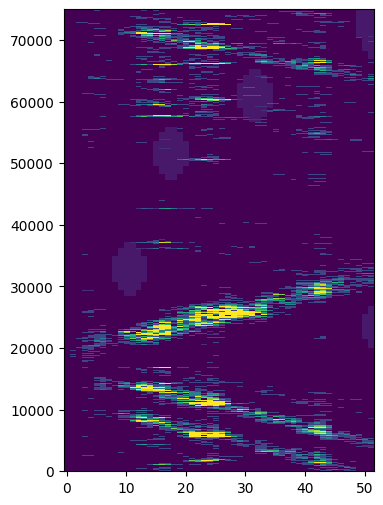


=== CLAHE (3.0, 4x4) ===


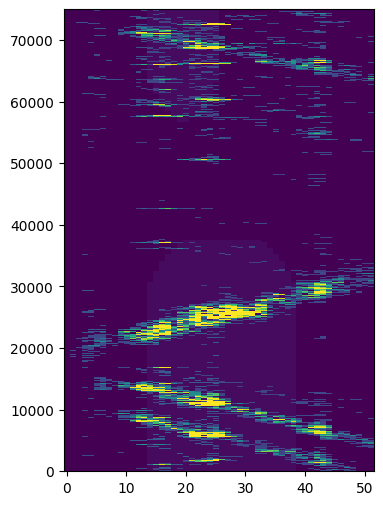


=== Sobel Y ===


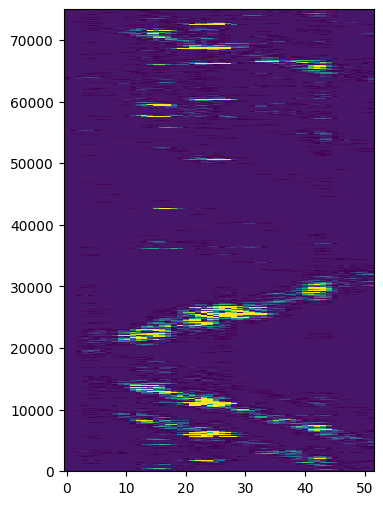


=== Sobel X ===


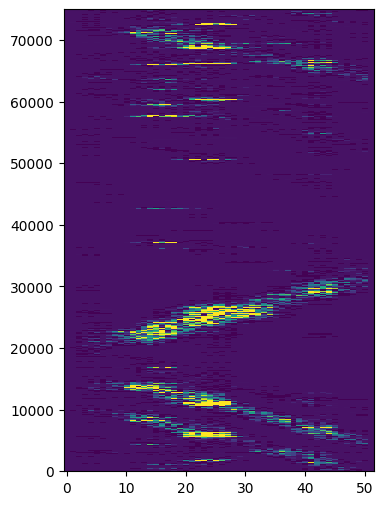


=== Scharr X ===


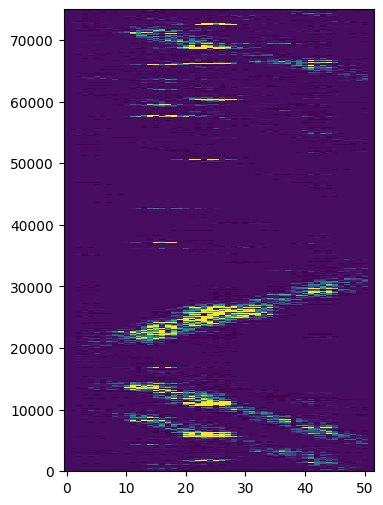


=== Scharr Y ===


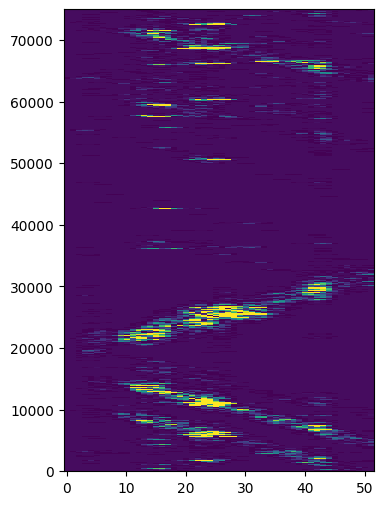


=== Laplacian ===


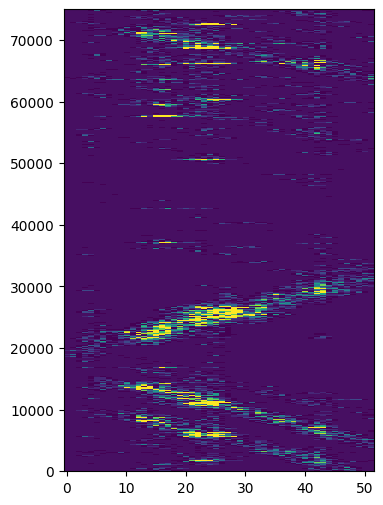


=== Top-hat 7x7 ===


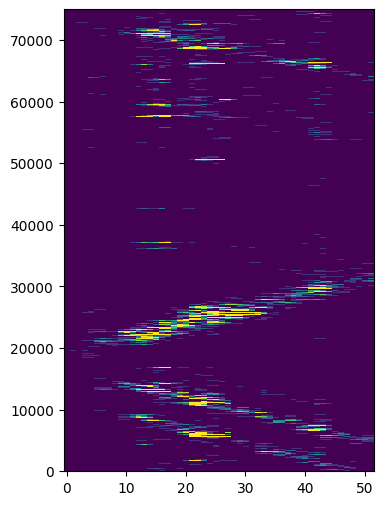


=== Black-hat 7x7 ===


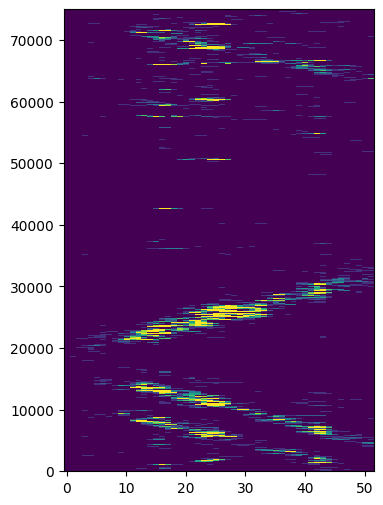


=== Opening 5x5 ===


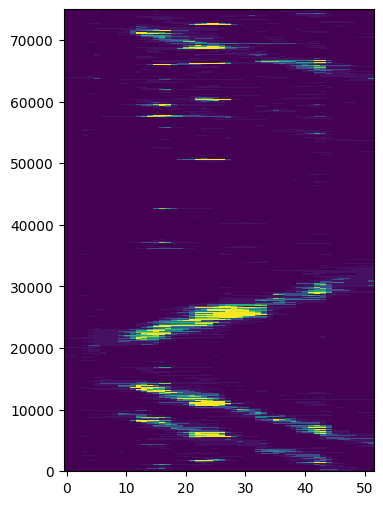


=== Closing 5x5 ===


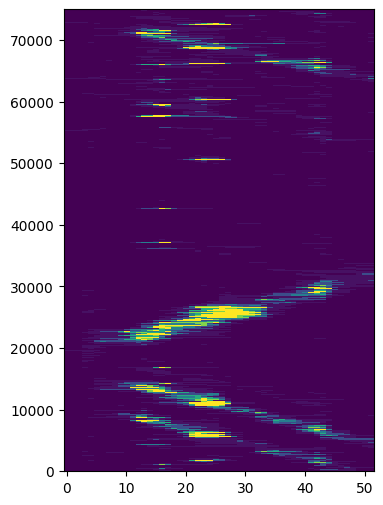


=== Sharpened ===


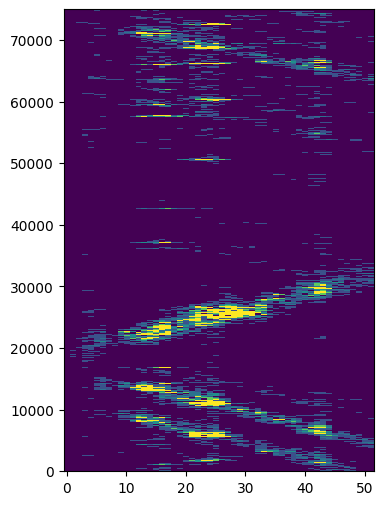


=== Median 5x5 ===


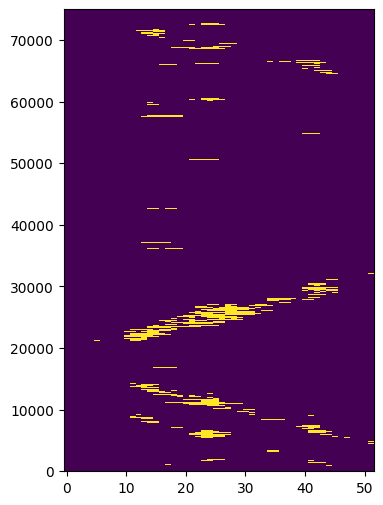


=== Bilateral ===


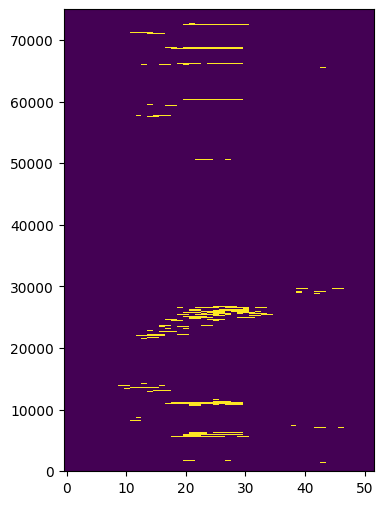


=== Histogram Equalization ===


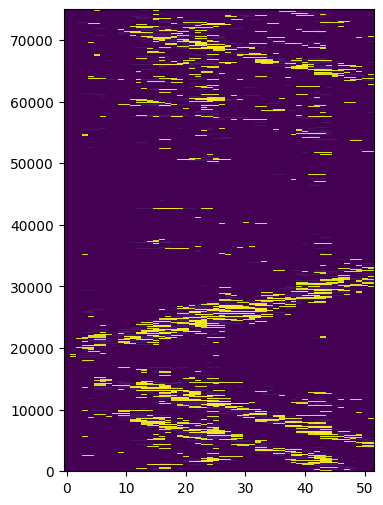


=== Gabor 0deg ===


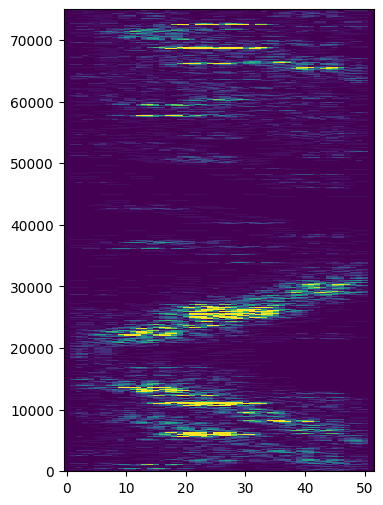


=== Gabor 45deg ===


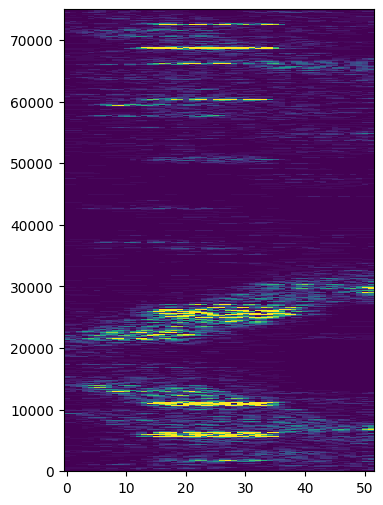


=== Gabor 90deg ===


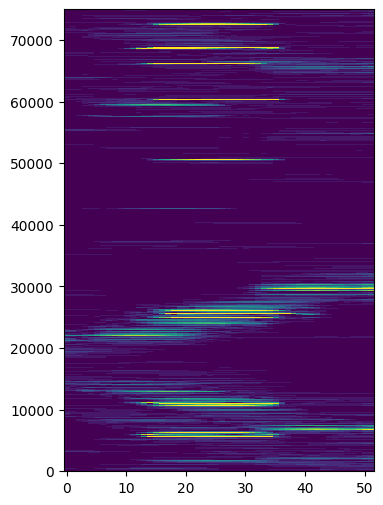


=== Gabor 135deg ===


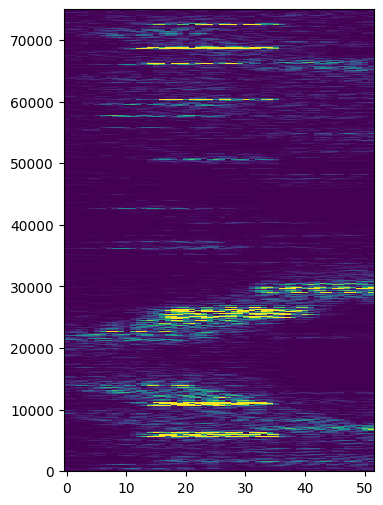

In [103]:
import cv2
import numpy as np

img = cv2.normalize(reverted_df.to_numpy(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def show(name, arr):
    print("\n=== " + name + " ===")
    visualize_df(arr, fs=(4,6))

# 1 — Original
show("Original", img)

# 2 — CLAHE (default)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
show("CLAHE (2.0, 8x8)", clahe.apply(img))

# 3 — CLAHE stronger
clahe2 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
show("CLAHE (3.0, 4x4)", clahe2.apply(img))

# 4 — Sobel horizontal
show("Sobel Y", cv2.convertScaleAbs(cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)))

# 5 — Sobel vertical
show("Sobel X", cv2.convertScaleAbs(cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)))

# 6 — Scharr X
show("Scharr X", cv2.convertScaleAbs(cv2.Scharr(img, cv2.CV_32F, 1, 0)))

# 7 — Scharr Y
show("Scharr Y", cv2.convertScaleAbs(cv2.Scharr(img, cv2.CV_32F, 0, 1)))

# 8 — Laplacian (edge emphasis)
lap = cv2.convertScaleAbs(cv2.Laplacian(img, cv2.CV_32F))
show("Laplacian", lap)

# 9 — Top-hat
kernel7 = np.ones((7,7), np.uint8)
show("Top-hat 7x7", cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel7))

# 10 — Black-hat
show("Black-hat 7x7", cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel7))

# 11 — Opening (denoise)
show("Opening 5x5", cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5,5), np.uint8)))

# 12 — Closing (fill gaps)
show("Closing 5x5", cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8)))

# 13 — Gaussian sharpening
blur = cv2.GaussianBlur(img, (0,0), 3)
sharp = cv2.addWeighted(img, 1.5, blur, -0.5, 0)
show("Sharpened", sharp)

# 14 — Median filter
show("Median 5x5", cv2.medianBlur(img, 5))

# 15 — Bilateral smoothing
show("Bilateral", cv2.bilateralFilter(img, 9, 75, 75))

# 16 — Histogram equalization
show("Histogram Equalization", cv2.equalizeHist(img))

# 17–20 — Gabor filters in 4 orientations
def gabor(theta):
    g = cv2.getGaborKernel((21,21), sigma=4.0, theta=theta, lambd=10, gamma=0.5)
    f = cv2.filter2D(img, cv2.CV_32F, g)
    return cv2.normalize(f, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show("Gabor 0deg", gabor(0))
show("Gabor 45deg", gabor(np.pi/4))
show("Gabor 90deg", gabor(np.pi/2))
show("Gabor 135deg", gabor(3*np.pi/4))
